## Generate geoJSON files for contours of inundation map

## References

1. [Extracting contours](https://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour)
2. [Python Path objects](https://matplotlib.org/api/path_api.html)
3. [Geojson package](https://pypi.org/project/geojson/)
4. [Python Path tutorial](https://matplotlib.org/users/path_tutorial.html)

### First import some necessary tools
Note: you'll need to install the geojson module to run this notebook. If you have pip you can simply run
>pip install geojson

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [222]:
from __future__ import print_function
from ptha_paths import data_dir, events_dir
import sys, os
from matplotlib import _cntr as cntr
from geojson import MultiPolygon, Feature, FeatureCollection, dump
from skimage import measure
import geojson

### Set parameters 

In [223]:
# Parameters
events = ['AASZa', 'AASZb', 'AASZc', 'AASZd', 'CSZa', 'CSZb', 'CSZc', 'CSZd', 'CSZe', \
              'CSZf', 'KmSZa', 'KrSZa', 'SChSZa', 'TOHa']     # The events to consider
sch = ['SChSZa']
num_levels = 2       # The number of levels to partition inundation into
zeta_level_values = [1e-2] + list(linspace(0.5,4.5,num_levels-1))

In [224]:
zeta_level_values

[0.01, 0.5]

### Read in the topography data and compute zeta-clines

In [225]:
# Read in topography data:
nx = 250
ny = 250

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0] - 360   # Longitudes
y=d[:,1]         # Latitudes
B=d[:,2]         # Bathymetry (topography in the absence of water)
topo = reshape(B, (nx,ny), order='F')
X = reshape(x, (nx,ny), order='F')  # X[0,0] is min long, X[-1, 0] is max long
Y = reshape(y, (nx,ny), order='F')  # Y[0,0] is min lat,  Y[0, -1] is max lat

In [226]:
# Loop over all events and compute zeta clines for each
# Collect zeta clines for each level in multi-polygon environments
# for event in events:
for event in sch:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    
    features = [None] * num_levels
    c = cntr.Cntr(X,Y,Hmax)
    path_list = []
    for k in xrange(num_levels):
        # Go from largest values to smallest to get appropriate overlapping
        # contours = c.trace(zeta_level_values[num_levels-k-1])  # this returns paths and categorical variables. Separate..
        contours = c.trace(zeta_level_values[num_levels-k-1])  # this returns paths and categorical variables. Separate..
        num_paths = len(contours) // 2   # Half of the entries correspond to path connection types
        path_list = [poly.tolist() for poly in contours[:num_paths]]  # grab the first half
        multi_poly = MultiPolygon([path_list])
        features[num_levels-k-1] = Feature(geometry=multi_poly)
    # features = Feature(geometry=multi_poly)    
    feature_collection = FeatureCollection(features)
    json_file = os.path.join(event_dir, 'contours.geojson')
    
    # Write to a file using geojson dump in the events dir (see first cell of this notebook)
    #with open(json_file, 'w') as outfile:
    #    dump(feature_collection, outfile)
    

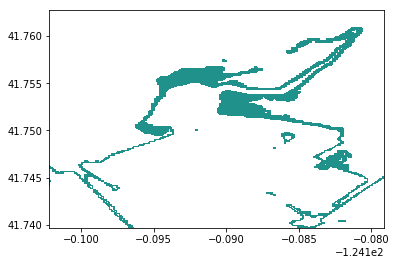

In [227]:
cs = plt.contourf(
    X, Y, Hmax, zeta_level_values)

In [205]:
from shapely.geometry import polygon
for i in range(len(cs.collections)):
    p = cs.collections[i].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    poly = Polygon([(j[0], j[1]) for j in zip(x,y)])
    print(i, poly)

0 Poly((-124.202, 41.7442) ...)


In [212]:
len(cs.collections[0].get_paths())

21

In [241]:
from shapely import geometry
import string
table = string.maketrans('()','[]')
table2 = string.maketrans('\'', '\"')
feature_collection = [None]*num_levels
# Loop through all zeta-levels
feats = []
for col in cs.collections:
    # Loop through all polygons that have the same intensity level
    feats = []
    for contour_path in col.get_paths(): 
        # Create the polygon for this intensity level
        # The first polygon in the path is the main one, the following ones are "holes"
        for ncp,cp in enumerate(contour_path.to_polygons()):
            x = cp[:,0]
            y = cp[:,1]
            new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
            # if ncp == 0:
            poly = new_shape
            print(poly)
            # else:
                # continue
                # Remove the holes if there are any
                #  poly = poly.difference(new_shape)
                # Can also be left out if you want to include all rings
            polyjson = {"geometry": geometry.mapping(poly), "type": "Feature"}
            feats.append(polyjson)
    #features[num_levels-k-1] = Feature(geometry=multi_poly)
# print(str({"type": "FeatureCollection", "features": feats}).translate(table).translate(table2))

POLYGON ((-124.2021890848759 41.744208, -124.2021890848759 41.7443, -124.2021889580017 41.744393, -124.2021889580017 41.744486, -124.2021888378142 41.744578, -124.2021888378142 41.744671, -124.20219 41.74467433967956, -124.20219 41.744763, -124.20219 41.744856, -124.20219 41.74487900752278, -124.2021581354772 41.744856, -124.2021581354772 41.74476300000001, -124.2021318907096 41.744671, -124.2021318907096 41.744578, -124.2021379000837 41.744486, -124.2021379000837 41.744393, -124.2021442437964 41.7443, -124.2021442437964 41.744208, -124.20219 41.74415740210756, -124.20219 41.74420698804215, -124.2021890848759 41.744208))
POLYGON ((-124.20219 41.74606, -124.20219 41.746152, -124.20219 41.74622578603067, -124.2021106601821 41.746152, -124.2021106601821 41.74606, -124.20209 41.74605852149291, -124.202 41.74605852149291, -124.2019114308133 41.745967, -124.2019114308133 41.745874, -124.20191 41.74585609361876, -124.20181 41.74585609361876, -124.2017375171121 41.745782, -124.2017375171121 41

# Everything below is experiments with contour plots in matplotlib.

In [42]:
from matplotlib import contour

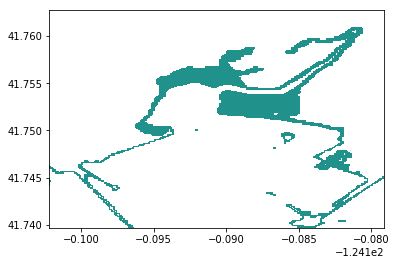

In [43]:
plt.contourf(X,Y,Hmax, zeta_level_values)

In [83]:
## example
xx = np.linspace(-1,1,nx)
XX = np.repeat(xx, nx).reshape(nx,ny)
YY = np.tile(xx, nx).reshape(nx,ny)
ZZ = XX**2 + YY**2
c = cntr.Cntr(XX, YY, ZZ)
contours = c.trace(0.5)  # the ZZ = 0.5 level-curve
num_paths = len(contours) // 2  # see this stackexchange link
# https://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour

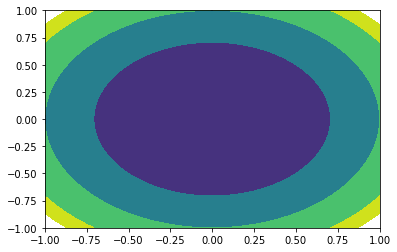

In [84]:
plt.contourf(XX,YY,ZZ,levels=[0,0.5,1,1.5,1.75])